# Derby Air Pollution Project

## Workflow

1) Get data from URL

2) Clean data

3) Plot graph per hour

4) Plot graph per day etc, do resampling

In [1]:
### Imports ###

from datetime import timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import seaborn as sns
import pandas as pd
from urllib.request import urlretrieve
from datetime import datetime

### Get data ###
URL_2020 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2020.csv'
URL_2019 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2019.csv'
URL_2018 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2018.csv'
URL_2017 = 'https://uk-air.defra.gov.uk/data_files/site_data/DESA_2017.csv' 


urlretrieve(URL_2020,'data_2020.csv')
urlretrieve(URL_2019,'data_2019.csv')
urlretrieve(URL_2018,'data_2018.csv')
urlretrieve(URL_2017,'data_2017.csv')

df_2020 = pd.read_csv('data_2020.csv',skiprows=4) # (skipping top 4 rows as they're empty)
df_2019 = pd.read_csv('data_2019.csv',skiprows=4)
df_2018 = pd.read_csv('data_2018.csv',skiprows=4)
df_2017 = pd.read_csv('data_2017.csv',skiprows=4)
unit = 'ugm^3'

### Cleaning data ###
# Issue with the data: 
# what should be "02-01-2020" and "00:00" is called "01-01-2020"  and "24:00" which Pandas doesn't like
# Need to take every instance where this happens and + 1 to the date and replace 24:00 with 00:00

def datetime_cleaner(variable):
    '''
    Function to take every date + time where date is i.e. 1/1/2020 24:00 and turn it into 2/1/2020 00:00
    Also removes redundant columns
    Doesn't set the index to the datetime though
    '''
    variable['Date'] = pd.to_datetime(variable['Date']).dt.strftime('%d-%m-%Y')
    variable['Date'] = pd.to_datetime(variable['Date'])

    # date + 1 for every 24th entry 
    counter = 0
    for i, row in variable.iterrows():
        counter += 1
        if counter % 24 == 0:
            value = variable.at[i,'Date'] + pd.Timedelta(1,unit='d')
            variable.at[i,'Date'] = value

    # cleaning up columns and data types in a really janky way
    variable['time'] = variable['time'].replace(to_replace='24:00',value='00:00')
    variable['Date String'] = variable['Date'].astype(str)
    variable['Date Time String'] = variable['Date String'] + " " + variable['time']
    variable['Date Time'] = pd.to_datetime(variable['Date Time String'])
    variable.drop(['Date','time','status','unit','status.1','unit.1','status.2','unit.2','Date String','Date Time String'],
                 axis=1,inplace=True)
    
    # making 'Date Time No Year' column
    variable['Date Time No Year'] = variable['Date Time'].dt.strftime('%d-%m %H:%M')
    
    # setting index to be the date time
    variable.index = variable['Date Time']
    
datetime_cleaner(df_2020)
datetime_cleaner(df_2019)
datetime_cleaner(df_2018)
datetime_cleaner(df_2017)

# Make new dataframe containing all data
frames = [df_2017,df_2018,df_2019,df_2020]

df_all = pd.concat(frames)
df_all_index = df_all.copy()
df_all_index.index = df_all_index['Date Time']

# Exploratory data analysis

In [87]:
# function to let you decide date range to plot
def plot_date_range(dateinput,resample_string,plottype,aggregate):
    '''
    Parameters:
    dateinput = date string in format YYYY-MM-DD
    resample = string of 'H'/'D'/'W'/'M'
    plottype = string 'line' or 'bar'
    aggregate = string 'sum','average','median'
    '''
    resample_string = resample_string.upper() # just in case user were to input h instead of H
    
    # for title of chart
    if resample_string == 'H':
        title_string = 'Hourly'
    elif resample_string == 'D':
        title_string = 'Daily'
    elif resample_string == 'W':
        title_string = 'Weekly'
    elif resample_string == 'M':
        title_string = 'Monthly'
    
    # date to plot from 
    dateinput_datetime = datetime.strptime(dateinput,'%Y-%m-%d')
    
    # resampling based on input
    if resample_string == 'H':
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        if plottype == 'line':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot(figsize=(15,10))
        elif plottype == 'bar':
            x = z[['Nitric oxide','Nitrogen dioxide']].plot.bar(figsize=(15,10))
        x.set_title('Hourly Emissions Since {}'.format(dateinput))
        x.set_ylim(0)
    else:    
        z = df_all_index[df_all_index.index>=dateinput_datetime]
        if plottype == 'line':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot(figsize=(15,10))
            elif aggregate == 'median': 
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot(figsize=(15,10))
            x.set_title('{} {} Emissions Since {}'.format(aggregate.title(),title_string,dateinput))
            x.set_ylim(0)
        elif plottype == 'bar':
            if aggregate == 'sum':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).sum().plot.bar(figsize=(15,10))
            elif aggregate == 'mean':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).mean().plot.bar(figsize=(15,10))
            elif aggregate == 'median':
                x = z[['Nitric oxide','Nitrogen dioxide']].resample(resample_string).median().plot.bar(figsize=(15,10))
            x.set_title('{} {} Emissions Since {}'.format(aggregate.title(),title_string,dateinput))
            x.set_ylim(0)

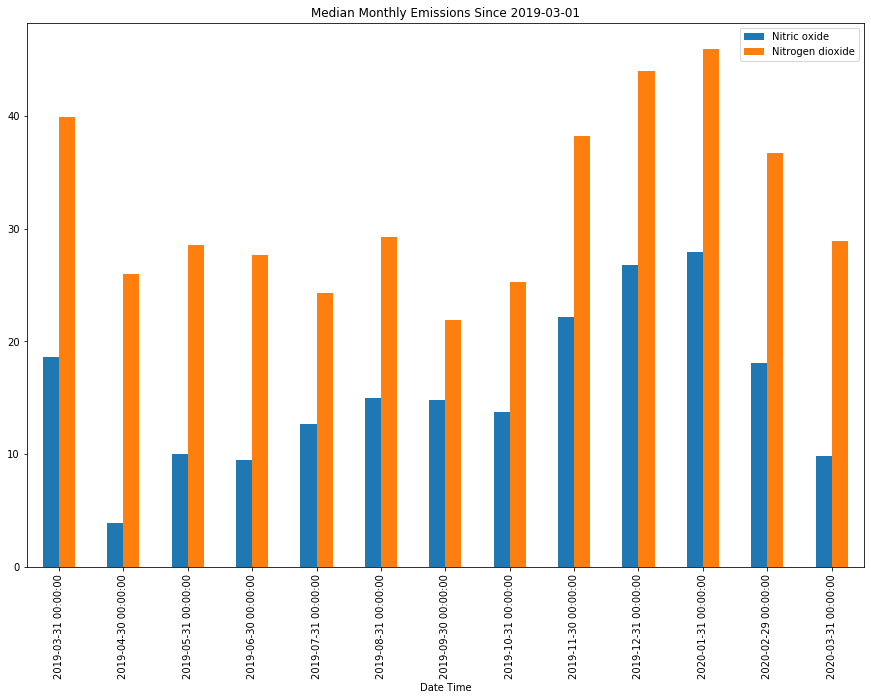

In [96]:
plot_date_range('2019-03-01','M','bar','median')

# BELOW IS WORK IN PROGRESS

## Plotting years on top on each other
I want to be able to have 2020 data plotted on top of 2019 data etc for easy comparison 
Will potentially involve stripping away year from datetime?

In [114]:
df_2020_noyear = df_2020.copy()
df_2020_noyear.index = df_2020_noyear['Date Time No Year']

In [115]:
df_2020_noyear = df_2020_noyear.drop(['Date Time','Date Time No Year'],axis=1)

In [116]:
df_2020_noyear

,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide
Date Time No Year,,,
01-01 01:00,0.65733,14.27299,15.28088
01-01 02:00,0.11600,13.12549,13.30335
01-01 03:00,1.62399,17.01551,19.50559
01-01 04:00,8.43892,29.44246,42.38196
01-01 05:00,7.33693,33.33440,44.58420
...,...,...,...
27-03 20:00,2.12041,22.75875,26.01000
27-03 21:00,1.12257,18.36000,20.08125
27-03 22:00,1.12257,13.96125,15.68250


In [132]:
def year_comparison(start,end):
    '''
    User inputs start and end date in format of MM-DD
    And multiple years are plotted on top of each other 
    '''
    # Making dataframes
    df_2020_noyear = df_2020.copy()
    df_2020_noyear.index = df_2020_noyear['Date Time No Year']
    df_2020_noyear = df_2020_noyear.drop(['Date Time','Date Time No Year'],axis=1)
    
    df_2019_noyear = df_2019.copy()
    df_2019_noyear.index = df_2019_noyear['Date Time No Year']
    df_2019_noyear = df_2019_noyear.drop(['Date Time','Date Time No Year'],axis=1
    
    df_2018_noyear = df_2018.copy(df_2018)
    df_2018_noyear.index = df_2018_noyear['Date Time No Year']
    df_2018_noyear = df_2018_noyear.drop(['Date Time','Date Time No Year'],axis=1
                                         
    df_2017_noyear = df_2017.copy()
    df_2027_noyear.index = df_2017_noyear['Date Time No Year']
    df_2017_noyear = df_2017_noyear.drop(['Date Time','Date Time No Year'],axis=1
                                        
    # making filtered dataframes                                     
    mask_2020 = (df_2020_noyear.index >= start_date) & (df_2020_noyear.index <= end_date)
    df_2020_date = df_2020_noyear.loc[mask]

    mask_2019 = (df_2019_noyear.index >= start_date) & (df_2019_noyear.index <= end_date)
    df_2019_date = df_2019_noyear.loc[mask]

    mask_2018 = (df_2018_noyear.index >= start_date) & (df_2018_noyear.index <= end_date)
    df_2018_date = df_2018_noyear.loc[mask]
                                         
    mask_2017 = (df_2017_noyear.index >= start_date) & (df_2017_noyear.index <= end_date)
    df_2017_date = df_2017_noyear.loc[mask]




SyntaxError: invalid syntax (<ipython-input-132-7e5b5eeb06dd>, line 15)

In [118]:
df_2020_date

,Nitric oxide,Nitrogen dioxide,Nitrogen oxides as nitrogen dioxide
Date Time No Year,,,
03-01 00:00,10.61390,25.29855,41.57297
03-01 01:00,7.30793,19.77589,30.98122
03-01 02:00,3.71197,13.66418,19.35578
03-01 03:00,2.58098,12.62680,16.58424
03-01 04:00,2.46498,12.22040,15.99998
...,...,...,...
03-03 19:00,30.80831,50.10750,97.34625
03-03 20:00,28.43844,48.00375,91.60875
03-03 21:00,39.41468,56.61000,117.04500


In [ ]:
mask = (df_2019['Date Time No Year'] > start_date) & (df_2019['Date Time No Year'] <= end_date)
df_2019_mar = df_2019.loc[mask]
df_2019_mar2 = df_2019_mar.copy() # making a copy with the year still present for resampling
df_2019_mar.index = df_2019_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it

mask = (df_2018['Date Time No Year'] > start_date) & (df_2018['Date Time No Year'] <= end_date)
df_2018_mar = df_2018.loc[mask]
df_2018_mar2 = df_2018_mar.copy() # making a copy with the year still present for resampling
df_2018_mar.index = df_2018_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it


mask = (df_2017['Date Time No Year'] > start_date) & (df_2017['Date Time No Year'] <= end_date)
df_2017_mar = df_2017.loc[mask]
df_2017_mar2 = df_2017_mar.copy() # making a copy with the year still present for resampling
df_2017_mar.index = df_2017_mar['Date Time No Year'] # getting rid of date time so there's no year to confuse it

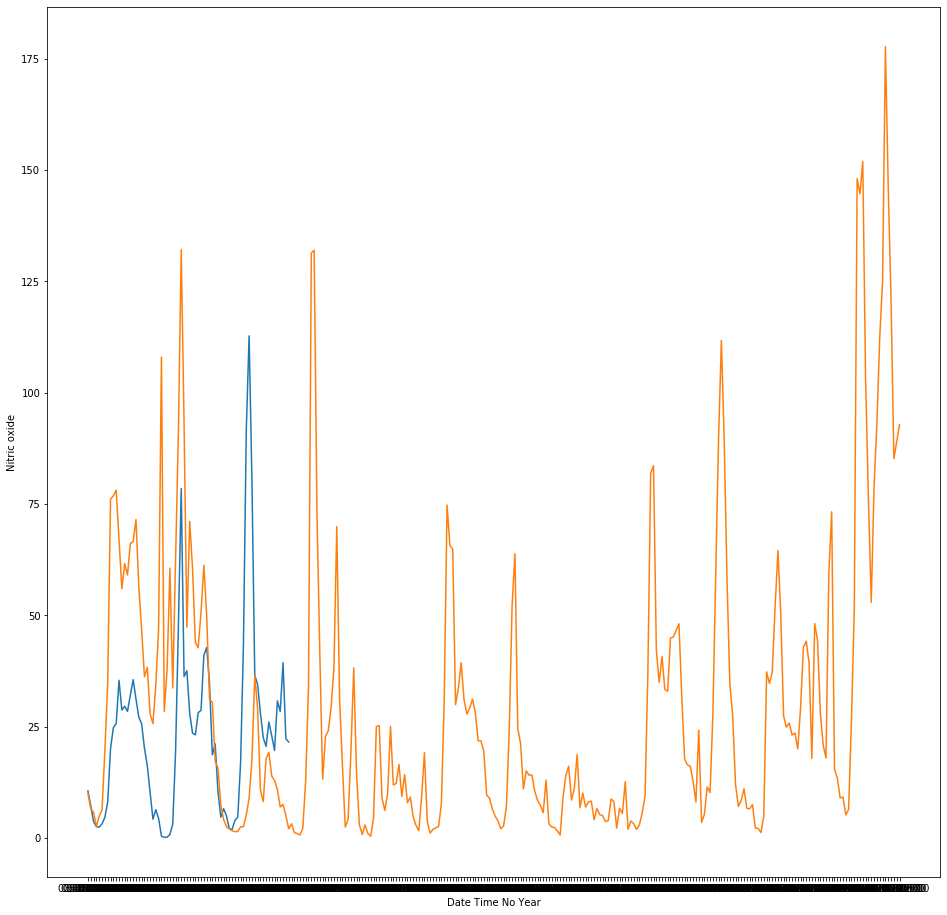

In [105]:
plt.figure(figsize=(16, 16))
sns.lineplot(x='Date Time No Year',y='Nitric oxide',data=df_2020_mar)
sns.lineplot(x='Date Time No Year',y='Nitric oxide',data=df_2019_mar)

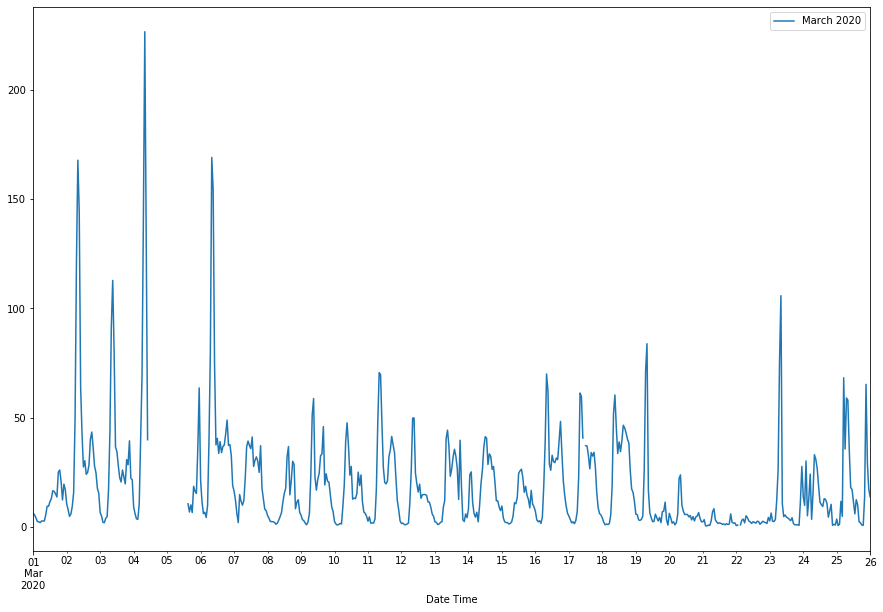

In [35]:
fig, ax = subplots()

df_2020_mar[['Date Time No Year','Nitric oxide']].plot(figsize=(15,10),ax=ax)
ax.legend(['March 2020'])


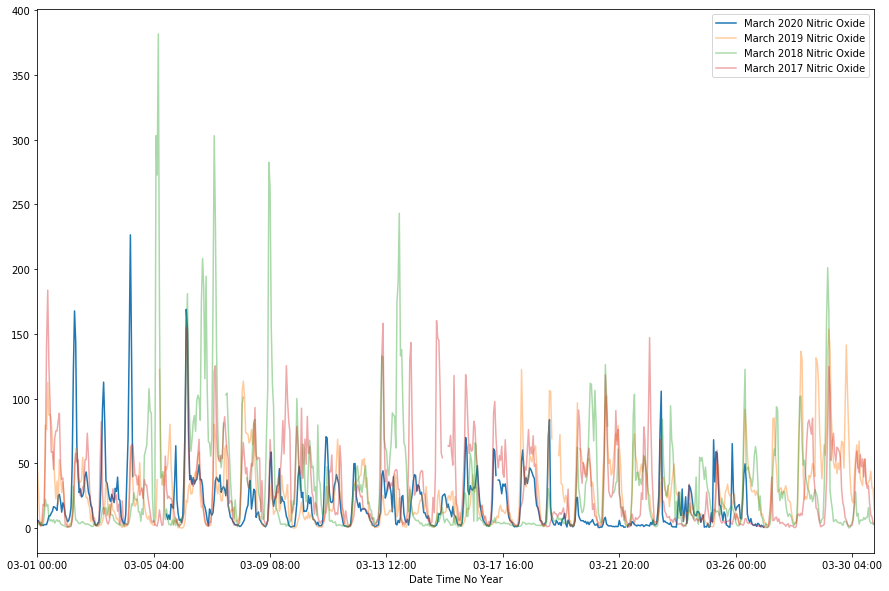

In [17]:
fig, ax = subplots()

df_2020_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax)
ax.legend(['March 2020'])
df_2019_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4)
ax.legend(['March 2020','March 2019'])
df_2018_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4)
ax.legend(['March 2020','March 2019','March 2018'])
df_2017_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4)
ax.legend(['March 2020 Nitric Oxide','March 2019 Nitric Oxide','March 2018 Nitric Oxide','March 2017 Nitric Oxide'])


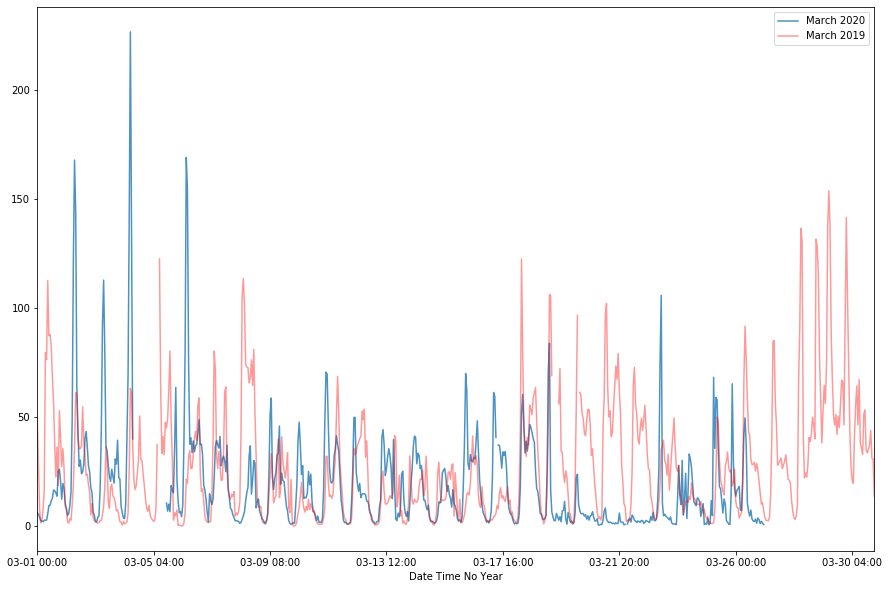

In [24]:
fig, ax = subplots()

df_2020_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.8)
ax.legend(['March 2020'])
df_2019_mar['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='red',ls='-')
ax.legend(['March 2020','March 2019'])

In [14]:
# resampling
df_2020_mar_day =df_2020_mar2.resample('D').sum()
df_2020_mar_day['Date Time No Year'] = df_2020_mar_day.index.strftime('%m-%d %H:%M')
df_2020_mar_day_noyear = df_2020_mar_day.copy()
df_2020_mar_day_noyear.index = df_2020_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

df_2019_mar_day =df_2019_mar2.resample('D').sum()
df_2019_mar_day['Date Time No Year'] = df_2019_mar_day.index.strftime('%m-%d %H:%M')
df_2019_mar_day_noyear = df_2019_mar_day.copy()
df_2019_mar_day_noyear.index = df_2019_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

df_2018_mar_day =df_2018_mar2.resample('D').sum()
df_2018_mar_day['Date Time No Year'] = df_2018_mar_day.index.strftime('%m-%d %H:%M')
df_2018_mar_day_noyear = df_2018_mar_day.copy()
df_2018_mar_day_noyear.index = df_2018_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

df_2017_mar_day =df_2017_mar2.resample('D').sum()
df_2017_mar_day['Date Time No Year'] = df_2017_mar_day.index.strftime('%m-%d %H:%M')
df_2017_mar_day_noyear = df_2017_mar_day.copy()
df_2017_mar_day_noyear.index = df_2017_mar_day_noyear['Date Time No Year'] # getting rid of date time so there's no year to confuse it

Text(0.5, 0, 'Date')

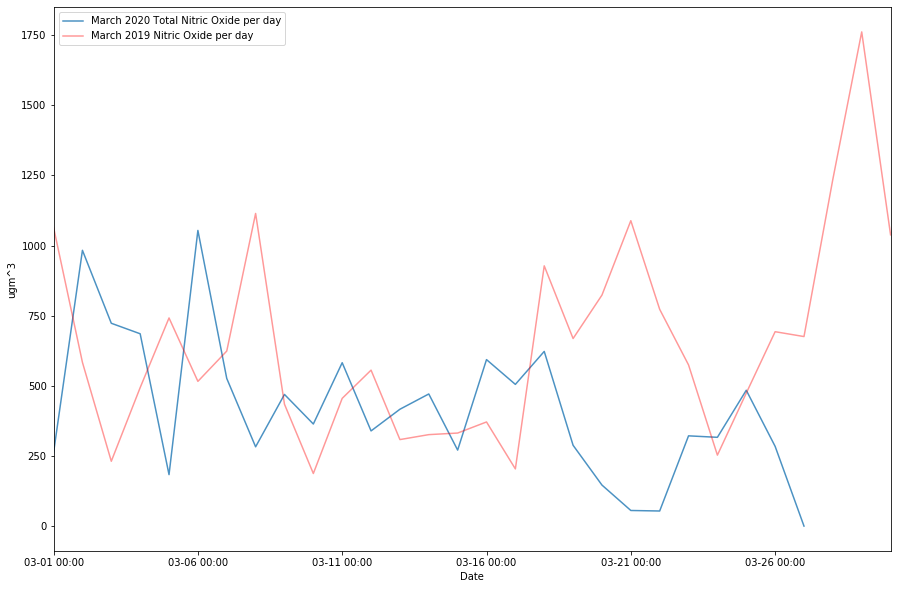

In [29]:
fig, ax = subplots()

df_2020_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.8)
ax.legend(['March 2020 Total Nitric Oxide per day'])
df_2019_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='red',ls='-')
ax.legend(['March 2020 Total Nitric Oxide per day','March 2019 Nitric Oxide per day'])
ax.set_ylabel(unit)
ax.set_xlabel('Date')
#ax.set_xticks(np.arange(len(df_2019_mar_day_noyear)))
#plt.xticks(rotation=90)

Text(0.5, 1.0, 'Total Nitric Oxide Per Day (ugm^3) in March 2020 vs 2019 vs 2018 vs 2017')

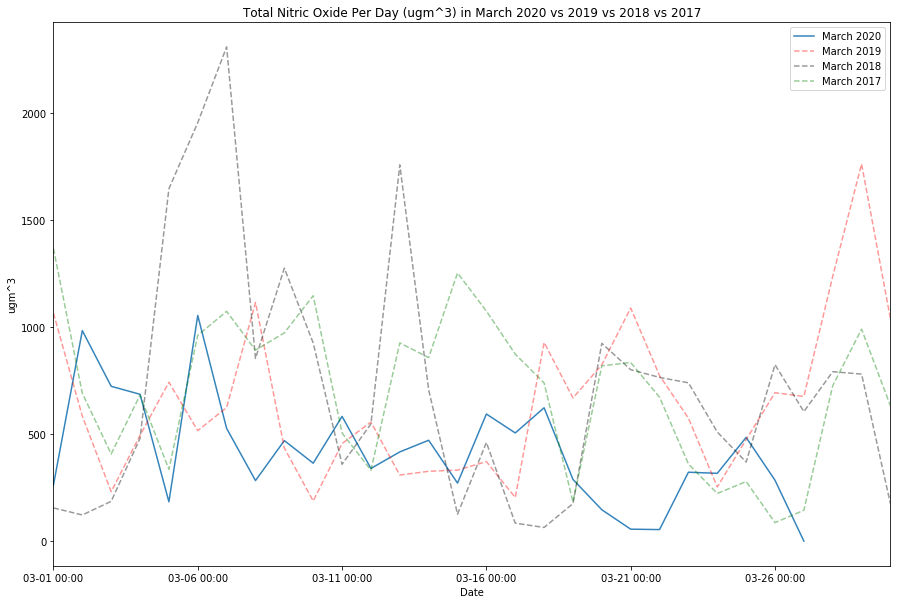

In [40]:
fig, ax = subplots()

df_2020_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.9)
df_2019_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='red',ls='--')
df_2018_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='black',ls='--')
df_2017_mar_day_noyear['Nitric oxide'].plot(figsize=(15,10),ax=ax,alpha=0.4,color='green',ls='--')
ax.legend(['March 2020',
           'March 2019',
          'March 2018',
           'March 2017'])
ax.set_ylabel(unit)
ax.set_xlabel('Date')
ax.set_title('Total Nitric Oxide Per Day (ugm^3) in March 2020 vs 2019 vs 2018 vs 2017')
#ax.set_xticks(np.arange(len(df_2019_mar_day_noyear)))
#plt.xticks(rotation=90)